In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt

sys.path.append('../bin')
from utils import load_corr_list
from desi_file_manager import DESIFileName
from local_file_manager import LocalFileName

# plotting
plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plots_dir = '../../plots/'

### Global parameters

In [2]:
# tracer
tracer = 'ELG'
region = 'SGC'

# mocks/version
version = 'v3'
imocks = range(25)

# multipoles
ells = (0, 2, 4)

# cut
rpcut = 0.
thetacut = 0.05

fn = DESIFileName()
fn.set_default_config(version=version, ftype='allcounts', tracer=tracer, region=region)

## Plots

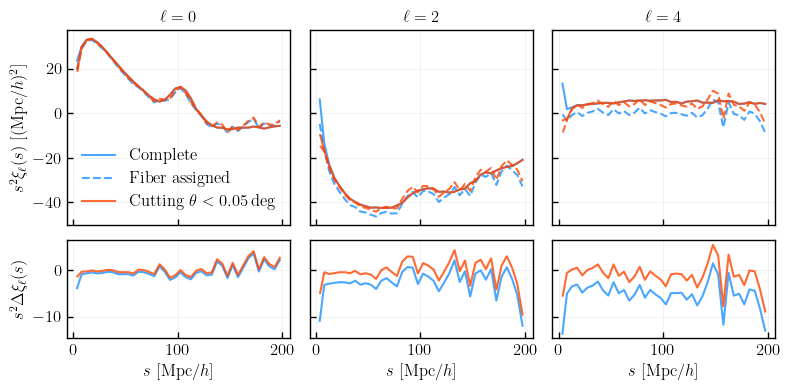

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(8, 4), sharey='row', sharex=True, gridspec_kw={'height_ratios': [4, 2]})

for c, cut in zip(['C0', 'C1'], [0., max(rpcut, thetacut)]):
    fn.set_default_config(completeness=False)
    poles = load_corr_list([fn.get_path(realization=imock, rpcut=min(cut, rpcut), thetacut=min(cut, thetacut)) for imock in imocks], rebin=5)
    fn.set_default_config(completeness=True)
    poles_complete = load_corr_list([fn.get_path(realization=imock, rpcut=min(cut, rpcut), thetacut=min(cut, thetacut)) for imock in imocks], rebin=5)
    for i, ell in enumerate(ells):
        axes[0][i].plot(poles_complete['sep'][i], poles_complete['sep'][i]**2 * poles_complete['data'][i], color=c, ls='-', alpha=0.8)
        axes[0][i].plot(poles['sep'][i], poles['sep'][i]**2 * poles['data'][i], color=c, ls='--', alpha=0.8)
        axes[1][i].plot(poles['sep'][i], poles['sep'][i]**2 * (poles['data'][i] - poles_complete['data'][i]), color=c, alpha=0.8)

axes[0][0].set_ylabel(r'$s^2 \xi_\ell (s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$s^2 \Delta \xi_\ell (s)$')

for i, ell in enumerate(ells):
    axes[1][i].set_xlabel('$s$ [Mpc/$h$]')
    axes[0][i].set_title(r'$\ell={}$'.format(ell))
    axes[0][i].plot([], [], ls='-', label='Complete', color='C0', alpha=0.8)
    axes[0][i].plot([], [], ls='--', label='Fiber assigned', color='C0', alpha=0.8)
    if rpcut:
        axes[0][i].plot([], [], ls='-', label='Cutting $r_{{\perp}} < {} \; \mathrm{{Mpc}}/h$'.format(rpcut), color='C1', alpha=0.8)
    if thetacut:
        axes[0][i].plot([], [], ls='-', label=r'Cutting $\theta < {} \deg$'.format(thetacut), color='C1', alpha=0.8)

axes[0][0].legend()
fig.align_ylabels()
plt.tight_layout(pad=0.3)
plt.savefig(os.path.join(plots_dir, version, 'corr_fiberassign_{}cut{}_{}_{}_{}mocks.pdf'.format('rp' if rpcut else 'theta', max(rpcut, thetacut), tracer, region, len(imocks))), dpi=200)
plt.show()

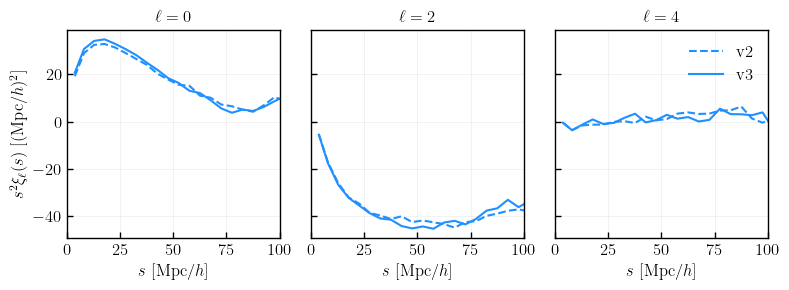

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharey='row', sharex=True)

fn = DESIFileName()
fn.set_default_config(version='v2', ftype='allcounts', tracer=tracer, region=region, completeness=False)
fn.update(zrange=(1.1, 1.6))
poles_v1 = load_corr_list([fn.get_path(realization=imock) for imock in imocks], rebin=5)

fn = DESIFileName()
fn.set_default_config(version='v3', ftype='allcounts', tracer=tracer, region=region, completeness=False)
fn.update(zrange=(1.1, 1.6))
poles_v3 = load_corr_list([fn.get_path(realization=imock) for imock in imocks], rebin=5)

for i, ell in enumerate(ells):
    axes[i].plot(poles_v1['sep'][i], poles_v1['sep'][i]**2 * poles_v1['data'][i], ls='--', label=r'v2', color='C0')
    axes[i].plot(poles_v3['sep'][i], poles_v3['sep'][i]**2 * poles_v3['data'][i], ls='-', label=r'v3', color='C0')

    axes[i].set_xlabel('$s$ [Mpc/$h$]')
    axes[i].set_title(r'$\ell={}$'.format(ell))
    axes[i].set_xlim((0, 100))

axes[0].set_ylabel(r'$s^2 \xi_\ell (s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()
fig.align_ylabels()
plt.show()